In [1]:
import torch
import pylab as plt

In [2]:
def softmin(z, epsilon):
    return -torch.logsumexp(-z/epsilon, dim=1)*epsilon

In [3]:
epsilon = 0.1

In [4]:
Nx = 100
Ny = 100

def sinkhorn(X, Y):
    X = X.double()
    Y = Y.double()
    Nx = X.shape[0]
    Ny = Y.shape[0]
    
    a = torch.ones(Nx).double()/Nx
    b = torch.ones(Ny).double()/Ny
    
    f = torch.ones(Nx).double()
    g = torch.zeros(Ny).double()

    C = torch.sum((X[:,None] - Y[None])**2, dim=2)
    Cmax = C.max()
    C = C/Cmax

    for i in range(500):
        S = C - f[:, None] - g[None]
        f = softmin(S, epsilon=epsilon) + f + epsilon * torch.log(a)
        S = C - f[:, None] - g[None]
        g = softmin(S.t(), epsilon=epsilon) + g + epsilon * torch.log(b)
        
    K = torch.exp(-C/epsilon)
    P = torch.diag(torch.exp(f/epsilon)) @ K @ torch.diag(torch.exp(g/epsilon))
        
    return torch.sum(P*C) * Cmax

In [5]:
X = torch.randn(100, 2) + torch.ones(2)

In [6]:
Y = torch.vstack([torch.cos(torch.linspace(0,10,50)), torch.sin(torch.linspace(0, 10, 50))]).t()*1.5

In [7]:
target_cov = torch.ones((2,2))*0.8

In [8]:
X.requires_grad = True

In [9]:
alpha=100

In [10]:
from torch.optim import Adam

In [11]:
optimizer = Adam([X], lr=0.1)

In [12]:
from tqdm import tqdm

  0%|          | 0/200 [00:00<?, ?it/s]

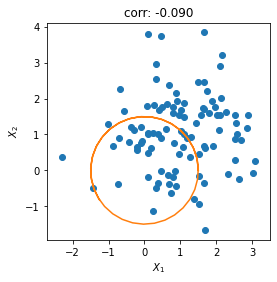

  5%|▌         | 10/200 [00:02<00:50,  3.76it/s]

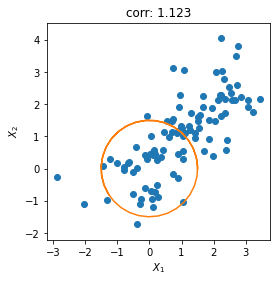

 10%|█         | 20/200 [00:05<00:45,  3.98it/s]

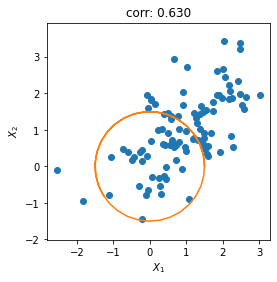

 15%|█▌        | 30/200 [00:08<00:42,  3.96it/s]

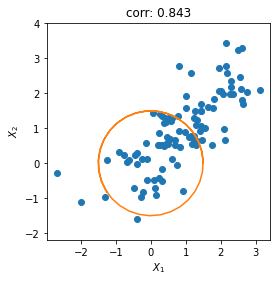

 20%|██        | 40/200 [00:10<00:40,  3.97it/s]

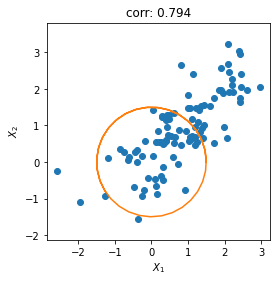

 25%|██▌       | 50/200 [00:13<00:37,  3.96it/s]

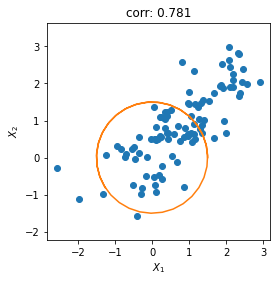

 30%|███       | 60/200 [00:16<00:35,  3.94it/s]

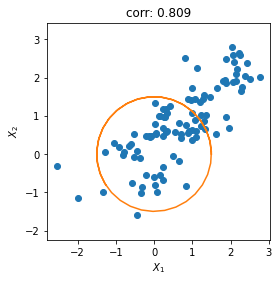

 35%|███▌      | 70/200 [00:18<00:32,  3.96it/s]

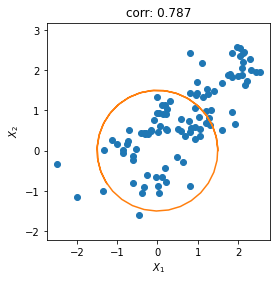

 40%|████      | 80/200 [00:21<00:30,  3.94it/s]

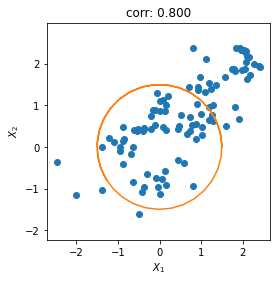

 45%|████▌     | 90/200 [00:24<00:27,  3.93it/s]

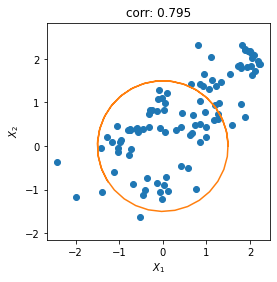

 50%|█████     | 100/200 [00:26<00:25,  3.93it/s]

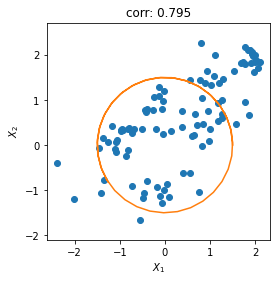

 55%|█████▌    | 110/200 [00:29<00:22,  3.92it/s]

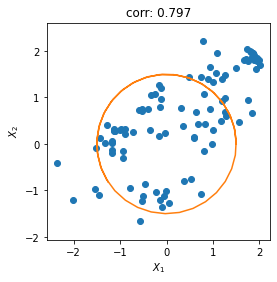

 60%|██████    | 120/200 [00:32<00:20,  3.91it/s]

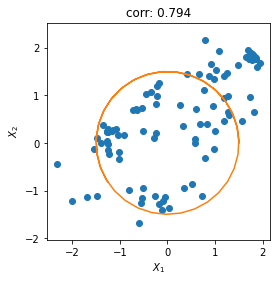

 65%|██████▌   | 130/200 [00:34<00:17,  3.91it/s]

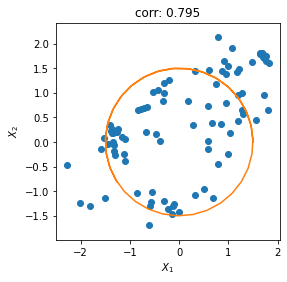

 70%|███████   | 140/200 [00:37<00:15,  3.89it/s]

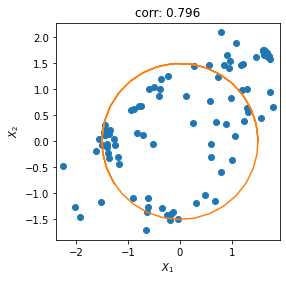

 75%|███████▌  | 150/200 [00:40<00:12,  3.90it/s]

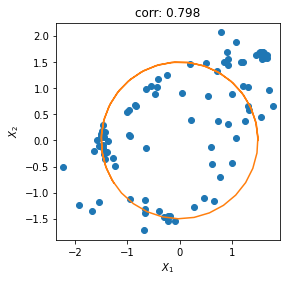

 80%|████████  | 160/200 [00:42<00:10,  3.90it/s]

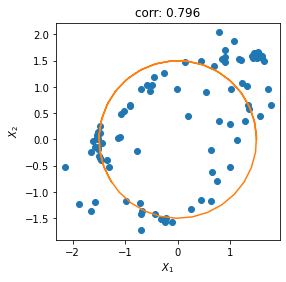

 85%|████████▌ | 170/200 [00:45<00:07,  3.91it/s]

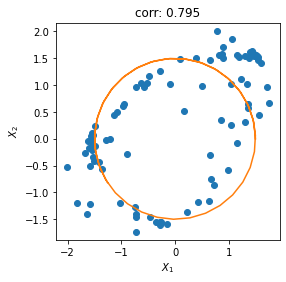

 90%|█████████ | 180/200 [00:48<00:05,  3.91it/s]

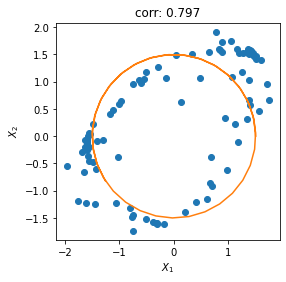

 95%|█████████▌| 190/200 [00:50<00:02,  3.89it/s]

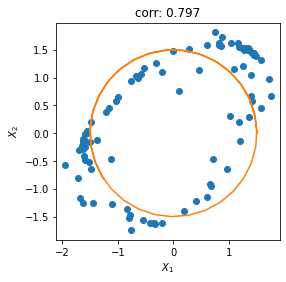

100%|██████████| 200/200 [00:53<00:00,  3.74it/s]


In [13]:
loss_hist = []
for i in tqdm(range(200)):
    normalized_X = (X - X.mean(dim=0))# .detach()
    cov = (normalized_X.t() @ normalized_X)/len(X)
    std = cov**0.5
    
    # cov_loss = torch.sum((cov - target_cov)**2)
    cov_loss = torch.sum((cov[0,1] - target_cov[0,1])**2)
    ot_loss = sinkhorn(X,Y)
    
    loss = ot_loss + alpha * cov_loss
    loss.backward()
    
    
    optimizer.step()
    optimizer.zero_grad()
    
    if i%10==0:
        plt.figure(figsize=((4,4)))

        plt.scatter(X[:,0].detach(), X[:,1].detach())
        plt.plot(Y[:,0].detach(), Y[:,1].detach(), c="C1")

        # print(ot_loss, cov_loss)
        plt.title("corr: %.3f"%(cov[0, 1].detach().numpy()) 
                  #+ " var 1: %.3f"%(cov[0, 0].detach().numpy()) 
                  #+ " var 2: %.3f"%(cov[1, 1].detach().numpy()) 
                 )

        plt.xlabel("$X_1$")
        plt.ylabel("$X_2$")
        plt.axis("equal")
        plt.savefig("%02d.png"%i)
        plt.show()
    
    
#     loss_hist.append(loss.detach().numpy())
#     plt.plot(loss_hist)
#     plt.show()